Import packages 

In [1]:
import sys
sys.path.append(str('/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/'))

import pandas as pd
import numpy as np


from configparser import ConfigParser
import datetime

from new_repo.MyConfigParser import MyConfigParser
from new_repo.LoadData import DataLoader
from new_repo.QueryingData import Combine
from new_repo.FileGenerator import *

import new_repo.Accuracy
import new_repo.BuildModel


Import at set the config file to a config dict

In [2]:

config_in_path = "/home/jupyter/GroupM_US_Offshore_Hub_Savant/All Regions/Account type/us/24 Sep Update/config ups US 24 Sep.ini"
config_file = MyConfigParser(config_in_path)
config_dict = config_file.GetDict()

region = config_dict['CLIENTINFO']['country']
cutoff_month = config_dict['PROPHETSETTING']['cut_off_point']
base_start = config_dict['PROPHETSETTING']['reference_start_date1']
base_end = config_dict['PROPHETSETTING']['reference_end_date1']
periods = config_dict['PROPHETSETTING']['periods']
base_periods  = config_dict['PROPHETSETTING']['base_periods']

training_query = config_dict["PROPHETSETTING"]["training_query"]
_input = config_dict["PROPHETSETTING"]["input"]
_output = config_dict["PROPHETSETTING"]["output"]

output_bucket = config_dict["FILEPATH"]["output_bucket"]
folder_name = config_dict["FILEPATH"]["folder_name"]


today = datetime.date.today().strftime("%m.%d.%Y") #'03.10.2023' #
print(today)
base_path = config_dict["FILEPATH"]["base_path"]

boundary_df_in_path = base_path + config_dict["FILEPATH"]["boundary_df_in_path"]
daily_df_out_path = base_path + config_dict["FILEPATH"]["daily_df_out_path"]
analytical_file_path = base_path + config_dict["FILEPATH"]["analytical_file_path"]
cuts_df_in_path = base_path + config_dict["FILEPATH"]["cuts_df_in_path"]
plot_name = base_path + config_dict["FILEPATH"]["plot_name"]
constraint_file_name = base_path + config_dict["FILEPATH"]["constraint_file_name"]


07.10.2024


In [3]:
# create a list of variable names that make each split 
query_item_list = [config_dict['CLIENTINFO'][i] for i in sorted([key for key in config_dict['CLIENTINFO'] if key.startswith('breakdown')]) if config_dict['CLIENTINFO'][i] != None]

query_item_list

['market', 'account_type', 'funnel']

query data

## Load historical data

In [ ]:
df = pd.read_csv(daily_df_out_path)
df.ds = pd.to_datetime(df.ds) # ensure ds is date_time type


In [8]:
df.head()

,region,market,account_type,funnel,ds,X,y,anomaly_2021,covid_year_dummy,weekday_or_weekend,jul_dec_2019,nov_dec_2018,mar_2018,apr_2019,may_2019,october_2022,november_2022,jan_feb_2023,Nov_dec_2023
0,US,US,Bing Ads,Brand,2017-08-10,1914.449980,1642.0,0,0,0,0,0,0,0,0,0,0,0,0
1,US,US,Bing Ads,Brand,2017-08-11,1872.470020,1578.0,0,0,0,0,0,0,0,0,0,0,0,0
2,US,US,Bing Ads,Brand,2017-08-12,0.050000,59.0,0,0,1,0,0,0,0,0,0,0,0,0
3,US,US,Bing Ads,Brand,2017-08-13,10.930000,66.0,0,0,1,0,0,0,0,0,0,0,0,0
4,US,US,Bing Ads,Brand,2017-08-14,1915.449955,1855.0,0,0,0,0,0,0,0,0,0,0,0,0


# Load Analytical file

In [ ]:
analytical_file = pd.read_csv(analytical_file_path)
analytical_file.ds = pd.to_datetime(analytical_file.ds) # ensure ds is date_time type


# Load cuts df

import cuts_df. Initial prophet hyper parameters the ones set on previous refresh

In [15]:
cuts_df = pd.read_csv(cuts_df_in_path) # import cuts_df

cuts_df['periods'] = periods # add column that inidcates number of periods to forecast
cuts_df['periods_for_acc_cal'] = 183 #periods # add number of periods that are left out of sample to calculate the accuracy 
cuts_df['cutoff_month'] = cutoff_month # add a column that sets the cuttof day of the data set 

cuts_df = cuts_df.rename(columns={'generic_cost_split':'cost_split_generic','competitor_cost_split':'cost_split_competitor'})

cuts_df

,market,account_type,funnel,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,include_holiday,...,generic_cost_split,competitor_cost_split,new_confirmed,Nov_Dec_2018,Jul_Dec_2019,power,growth,periods,periods_for_acc_cal,cutoff_month
0,US,Google AdWords,Competitor,0.05,10.0,0.01,additive,multiplicative,na,na,...,na,na,na,na,na,na,logistic,251.0,183,2024-04-24
1,US,Google AdWords,Generic,1.00,0.1,10.00,multiplicative,multiplicative,additive,na,...,na,na,na,na,na,na,linear,251.0,183,2024-04-24
2,US,Google AdWords,Brand,0.05,1.0,1.00,additive,additive,na,Default,...,na,na,na,na,na,na,linear,251.0,183,2024-04-24
3,US,Bing Ads,Competitor,0.50,1.0,0.10,additive,additive,na,na,...,na,na,na,na,na,na,linear,251.0,183,2024-04-24
4,US,Bing Ads,Generic,0.50,1.0,0.01,additive,additive,additive,na,...,na,na,na,na,na,0.01,logistic,251.0,183,2024-04-24
5,US,Bing Ads,Brand,0.05,10.0,0.01,multiplicative,multiplicative,additive,na,...,na,na,na,na,na,na,logistic,251.0,183,2024-04-24


## create the custom holidays

In [4]:

Blackfriday = pd.DataFrame({
    'holiday': 'Blackfriday', 
    'ds': pd.to_datetime(['2018-11-23', '2019-11-29', '2020-11-27', '2021-11-26', '2022-11-25','2023-11-24','2024-11-29']),
    'lower_window': -7,
    'upper_window': 7})

CyberMon = pd.DataFrame({
    'holiday': 'CyberMon', 
    'ds': pd.to_datetime(['2018-11-26', '2019-12-02', '2020-11-29', '2021-11-29', '2022-11-28','2023-11-27','2024-11-27']),
    'lower_window': 0,
    'upper_window': 7})

Valentines = pd.DataFrame({
    'holiday': 'Valentines', 
    'ds': pd.to_datetime(['2018-02-14', '2019-02-14', '2020-02-14', '2021-02-14', '2022-02-14','2023-02-14','2024-02-14']),
    'lower_window': -3,
    'upper_window': 1})

Mothers = pd.DataFrame({
    'holiday': 'Mothers',
    'ds': pd.to_datetime(['2018-05-13', '2019-05-12', '2020-05-26', '2021-05-09', '2022-05-08','2023-05-14','2024-05-12']),
    'lower_window': -7,
    'upper_window': 1
})

Independence = pd.DataFrame({
    'holiday': 'Independence',
    'ds': pd.to_datetime(['2018-07-04', '2019-07-04', '2020-07-03', '2021-07-05', '2022-07-04','2023-07-04','2023-07-04','2024-07-04']),
    'lower_window': -7,
    'upper_window': 1
})

Labor = pd.DataFrame({
    'holiday': 'Labor',
    'ds': pd.to_datetime(['2018-09-03', '2019-09-02', '2020-09-07', '2021-09-06', '2022-09-05','2023-09-04','2024-09-02']),
    'lower_window': -7,
    'upper_window': 1
})
Christmas = pd.DataFrame({
    'holiday': 'Christmas',
    'ds': pd.to_datetime(['2018-12-25', '2019-12-25', '2020-12-25', '2021-12-25', '2022-12-25','2023-12-25','2024-12-25']),
    'lower_window': -7,
    'upper_window': 1
})

custom_holidays = pd.concat(( Blackfriday, CyberMon, Valentines, Mothers, Independence, Labor, Christmas))


customized_holidays = {'US':custom_holidays}

# Accuracy based on previous refresh

##### First check the accuracy based on previous refresh

create accuracy table for each split 

In [ ]:
NewAccuracyCalc = new_repo.Accuracy.AccuracyCalculator() 
new_accuracy_df = NewAccuracyCalc.CalculateAccuracy(cuts_df = new_cuts_df, df = df, breakdown_ls = query_item_list, customized_holidays = customized_holidays)


In [19]:

new_accuracy = new_accuracy_df.groupby(query_item_list).mean(numeric_only=1) # group by split 
new_accuracy['Accuracy'] = np.where(new_accuracy['MAPE'] > 100, 'MAPE above 100%', 100 - new_accuracy['MAPE']) # create accuracy from MAPE 
new_accuracy['Forecast Period Accuracy'] = np.where(new_accuracy['Forecast Period APE'] > 100, 'Forecast Period APE above 100%', 100 - new_accuracy['Forecast Period APE']) # create period accuracy from period MAPE
new_accuracy.drop(columns=['MAPE','Forecast Period APE'], inplace=True) # drop error columns 
new_accuracy.rename(columns = {'Percentage Error': 'Mean Percentage Error'}, inplace = True) # rename columns
new_accuracy


  0%|          | 0/6 [00:00<?, ?it/s]16:00:37 - cmdstanpy - INFO - Chain [1] start processing


Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Competitor'


16:00:37 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:12,  2.48s/it]16:00:40 - cmdstanpy - INFO - Chain [1] start processing


Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Generic'


16:00:41 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:04<00:08,  2.20s/it]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Brand'


16:00:42 - cmdstanpy - INFO - Chain [1] start processing
16:00:42 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:05<00:05,  1.78s/it]16:00:43 - cmdstanpy - INFO - Chain [1] start processing


Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Competitor'


16:00:43 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:07<00:03,  1.61s/it]16:00:44 - cmdstanpy - INFO - Chain [1] start processing
16:00:44 - cmdstanpy - INFO - Chain [1] done processing


Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Generic'


 83%|████████▎ | 5/6 [00:07<00:01,  1.25s/it]16:00:45 - cmdstanpy - INFO - Chain [1] start processing


Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Brand'


16:00:45 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:10<00:00,  1.74s/it]


Actual       Forecast  \
market account_type   funnel                                     
US     Bing Ads       Brand        41784.714286   51798.890000   
                      Competitor   18461.142857   27084.848571   
                      Generic        608.857143     327.780000   
       Google AdWords Brand       382474.571429  402615.991429   
                      Competitor    8532.285714   11497.008571   
                      Generic       9260.428571    8633.454286   

                                  Mean Percentage Error            Accuracy  \
market account_type   funnel                                                  
US     Bing Ads       Brand                  -34.621429               50.69   
                      Competitor             -54.270000               41.07   
                      Generic                -36.244286  17.769999999999996   
       Google AdWords Brand                   -4.637143                86.1   
                      Competitor             -47.762857     MAPE above 100%   
                      Generic                  3.270000               91.56   

                                 Forecast Period Accuracy  
market account_type   funnel                               
US     Bing Ads       Brand                         76.03  
                      Competitor                    53.29  
                      Generic          53.839999999999996  
       Google AdWords Brand                         94.73  
                      Competitor                    65.25  
                      Generic                       93.23

plot accuracy for each month by split 

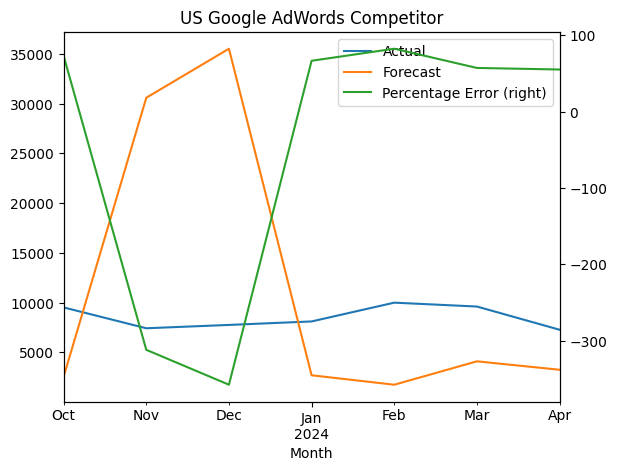

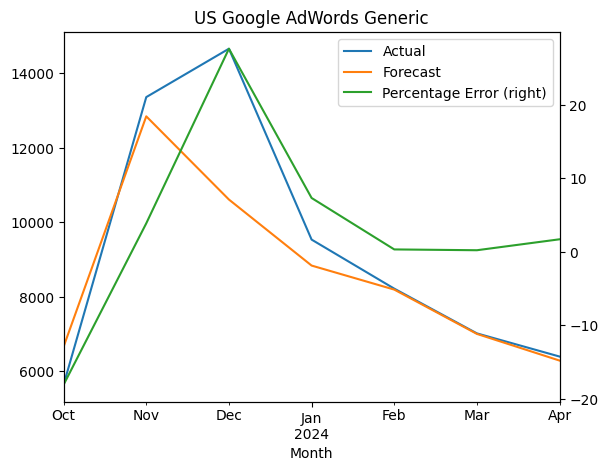

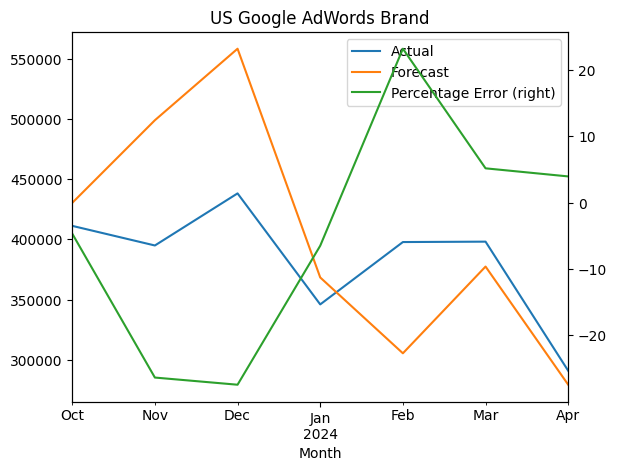

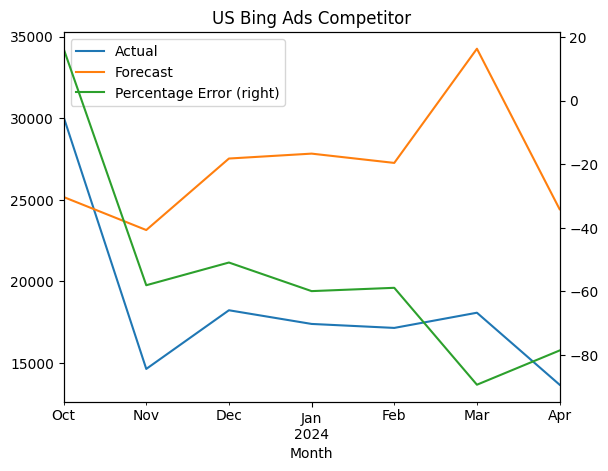

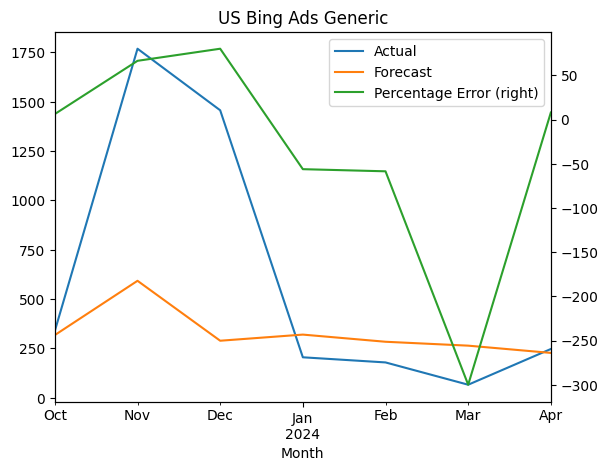

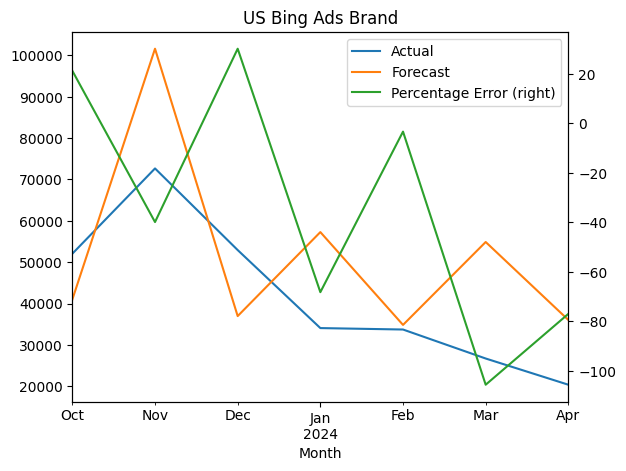

In [20]:
new_repo.Accuracy.PlotAccuracyCharts(accuracy_df, cuts_df, query_item_list)


# Prophet parameter search

create a hyper parameter grid 

In [21]:
param_grid = {
    'changepoint_prior_scale': [  0.05, 0.001], # 0.1,
    'seasonality_prior_scale': [ 0.01, 1.0 ], #10.0, 0.1,
    'holidays_prior_scale': [10.0, 0.01  ], # , 1.0,  0.1
    'seasonality_mode': ['additive','multiplicative'], #
    'input_mode': ['additive','multiplicative'], #
    'weekday_or_weekend':['na', 'multiplicative'],  #, 'additive'
    'include_holiday': [ 'default', 'customized'],# 'na',
    'covid_year_exclude':['False'],# ,'True'
    'covid_year_dummy':['na'],#, 'additive', 'multiplicative'],
    'anomaly_2021':['na'],#, 'additive', 'multiplicative'],
    'cost_split_generic':['na'],#, 'additive', 'multiplicative'
    'cost_split_competitor':['na'], #, 'additive', 'multiplicative'
    'new_confirmed': ['na'],#, 'additive', 'multiplicative'
    'growth':['linear', 'logistic'] #, 'power'
}



In [ ]:
# set the prophet parameter search with the hyper parameter grid created above and power flag as false (not needed)
search_engine = new_repo.Accuracy.ProphetParameterSearch(df = df, cuts_df = new_cuts_df.loc[new_cuts_df['account_type']=='Google AdWords'], breakdown_ls = query_item_list, param_grid = param_grid, customized_holidays = customized_holidays, base_path=base_path) 
grid_brand = search_engine.search() # performs the grid search over the hyper parameter grid. exports a best result .csv table with best hyper parameters by split and a record df .csv table with full hyper parameters results # 



256 possible combinations of hyper parameters


  0%|          | 0/3 [00:00<?, ?it/s]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Competitor'


 33%|███▎      | 1/3 [16:09<32:18, 969.48s/it]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Generic'


# Accuracy with new hyper parameters

#### Set new Cuts_df with the new hyper parameters for prophet after the ProphetParameterSearch

In [6]:
New_Cuts_df = pd.read_csv(base_path + 'new_cuts_df.csv')
New_Cuts_df['periods'] = periods # add column that inidcates number of periods to forecast
New_Cuts_df['periods_for_acc_cal'] = 183 #periods # add number of periods that are left out of sample to calculate the accuracy 
New_Cuts_df['cutoff_month'] = cutoff_month # add a column that sets the cuttof day of the data set 
New_Cuts_df = New_Cuts_df.rename(columns={'generic_cost_split':'cost_split_generic','competitor_cost_split':'cost_split_competitor'})

New_Cuts_df

,changepoint_prior_scale,seasonality_prior_scale,holidays_prior_scale,seasonality_mode,input_mode,weekday_or_weekend,include_holiday,covid_year_exclude,covid_year_dummy,anomaly_2021,...,growth,power,market,account_type,funnel,MAPE,period_APE,periods,periods_for_acc_cal,cutoff_month
0,0.001,1.00,10.00,multiplicative,multiplicative,multiplicative,customized,False,na,na,...,logistic,na,US,Google AdWords,Competitor,37.02,33.59,251.0,183,2024-04-24
1,0.050,0.01,10.00,additive,multiplicative,multiplicative,default,False,na,na,...,logistic,na,US,Google AdWords,Generic,40.84,16.36,251.0,183,2024-04-24
2,0.001,1.00,10.00,additive,additive,multiplicative,default,False,na,na,...,logistic,na,US,Google AdWords,Brand,14.74,0.53,251.0,183,2024-04-24
3,0.001,0.01,10.00,multiplicative,multiplicative,multiplicative,customized,False,na,na,...,linear,na,US,Bing Ads,Competitor,21.61,17.40,251.0,183,2024-04-24
4,0.001,1.00,0.01,multiplicative,multiplicative,multiplicative,default,False,na,na,...,logistic,na,US,Bing Ads,Generic,45.81,61.89,251.0,183,2024-04-24
5,0.050,0.01,0.01,additive,multiplicative,multiplicative,customized,False,na,na,...,logistic,na,US,Bing Ads,Brand,19.63,4.92,251.0,183,2024-04-24


In [ ]:
NewAccuracyCalc = new_repo.Accuracy.AccuracyCalculator() 
new_accuracy_df = NewAccuracyCalc.CalculateAccuracy(cuts_df = New_Cuts_df, df = df, breakdown_ls = query_item_list, customized_holidays = customized_holidays)


In [33]:

new_accuracy = new_accuracy_df.groupby(query_item_list).mean(numeric_only=1) # group by split 
new_accuracy['Accuracy'] = np.where(new_accuracy['MAPE'] > 100, 'MAPE above 100%', 100 - new_accuracy['MAPE']) # create accuracy from MAPE 
new_accuracy['Forecast Period Accuracy'] = np.where(new_accuracy['Forecast Period APE'] > 100, 'Forecast Period APE above 100%', 100 - new_accuracy['Forecast Period APE']) # create period accuracy from period MAPE
new_accuracy.drop(columns=['MAPE','Forecast Period APE'], inplace=True) # drop error columns 
new_accuracy.rename(columns = {'Percentage Error': 'Mean Percentage Error'}, inplace = True) # rename columns
new_accuracy


  0%|          | 0/6 [00:00<?, ?it/s]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Competitor'


19:28:52 - cmdstanpy - INFO - Chain [1] start processing
19:28:52 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:02<00:13,  2.80s/it]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Generic'


19:28:54 - cmdstanpy - INFO - Chain [1] start processing
19:28:54 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:05<00:11,  2.87s/it]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Brand'


19:28:57 - cmdstanpy - INFO - Chain [1] start processing
19:28:57 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:08<00:08,  2.89s/it]

Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Competitor'


19:29:00 - cmdstanpy - INFO - Chain [1] start processing
19:29:00 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:09<00:04,  2.24s/it]

Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Generic'


19:29:01 - cmdstanpy - INFO - Chain [1] start processing
19:29:01 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:10<00:01,  1.79s/it]

Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Brand'


19:29:02 - cmdstanpy - INFO - Chain [1] start processing
19:29:03 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Actual       Forecast  \
market account_type   funnel                                     
US     Bing Ads       Brand        41784.714286   36475.910000   
                      Competitor   18461.142857   14861.838571   
                      Generic        608.857143       0.732857   
       Google AdWords Brand       382474.571429  377714.022857   
                      Competitor    8532.285714       5.754286   
                      Generic       9260.428571    7354.912857   

                                  Mean Percentage Error             Accuracy  \
market account_type   funnel                                                   
US     Bing Ads       Brand                    9.658571                83.91   
                      Competitor              16.715714                83.28   
                      Generic                 99.850000  0.15000000000000568   
       Google AdWords Brand                    2.437143                81.18   
                      Competitor              99.932857  0.07000000000000739   
                      Generic                 35.655714    9.349999999999994   

                                 Forecast Period Accuracy  
market account_type   funnel                               
US     Bing Ads       Brand                         87.29  
                      Competitor                     80.5  
                      Generic         0.12000000000000455  
       Google AdWords Brand                         98.76  
                      Competitor      0.07000000000000739  
                      Generic                       79.42

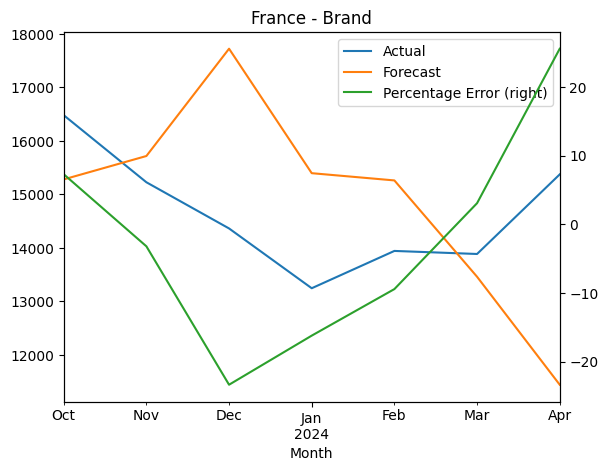

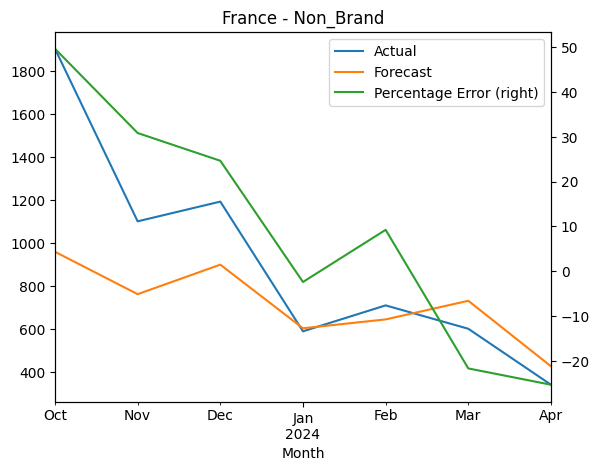

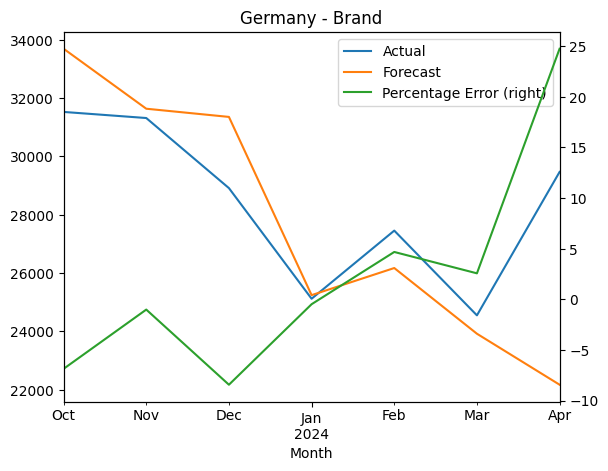

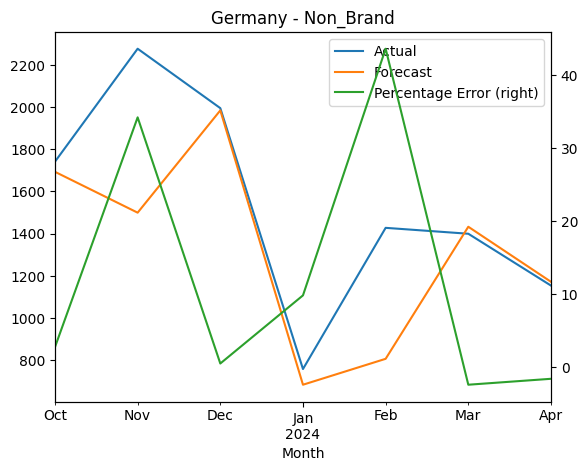

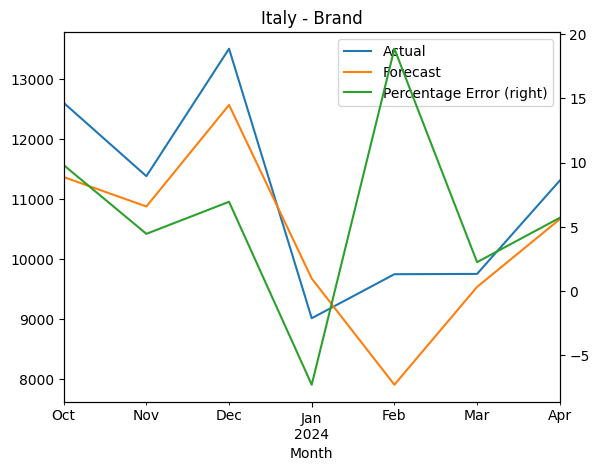

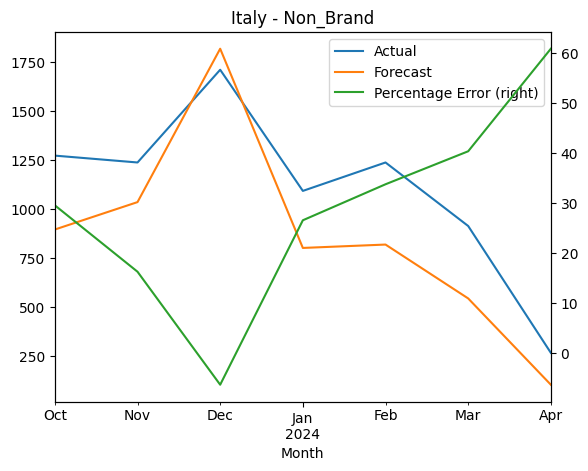

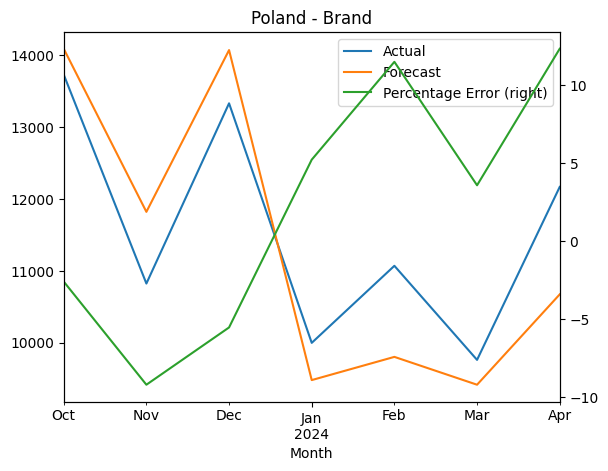

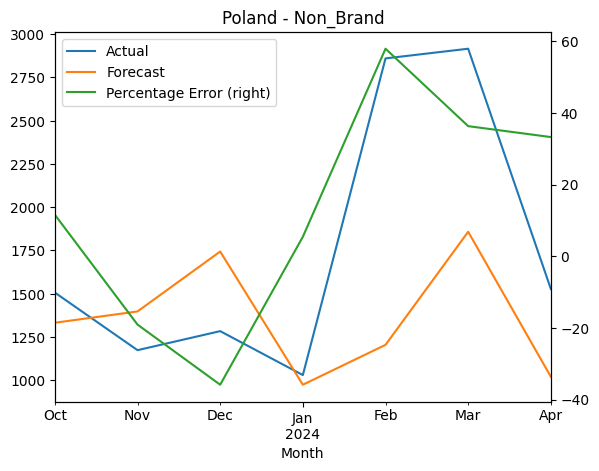

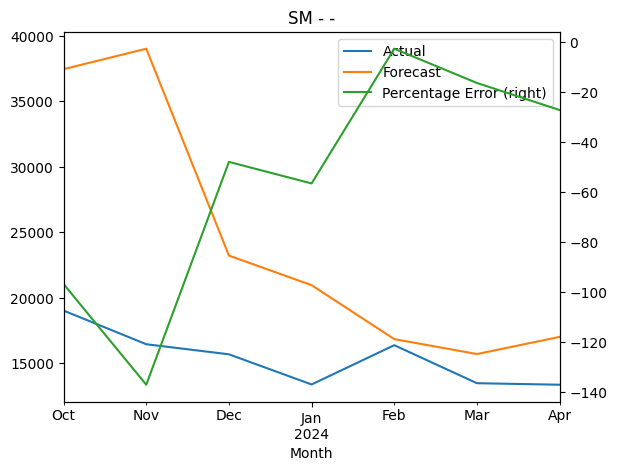

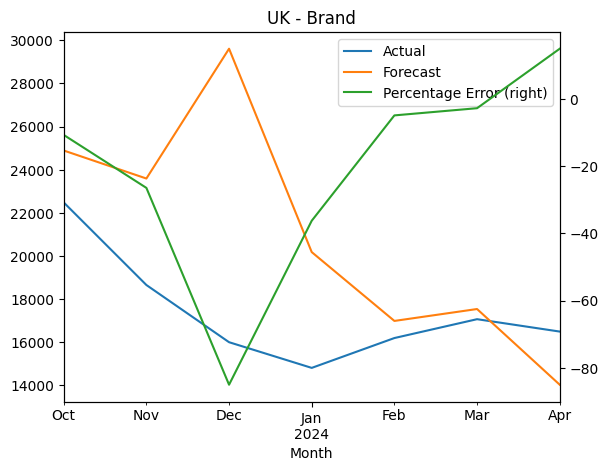

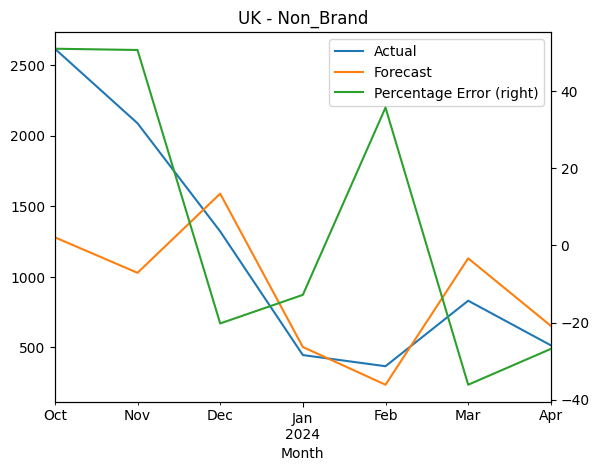

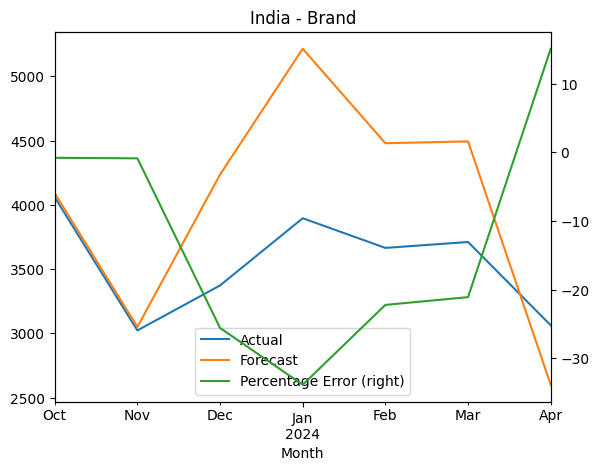

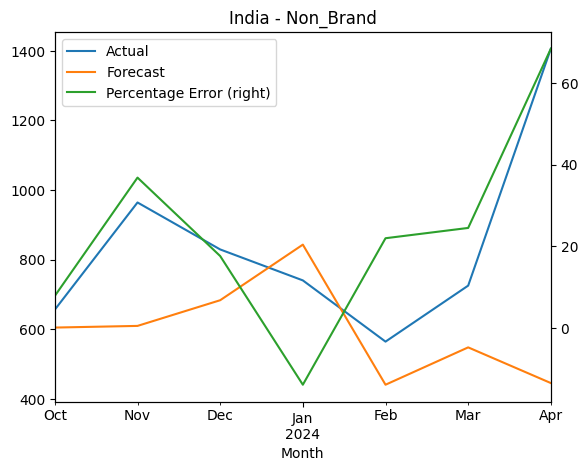

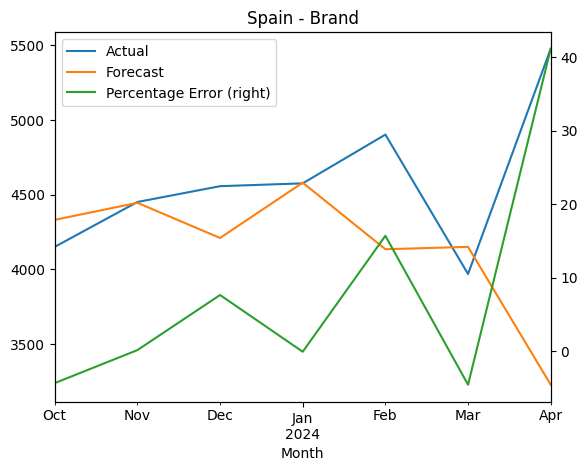

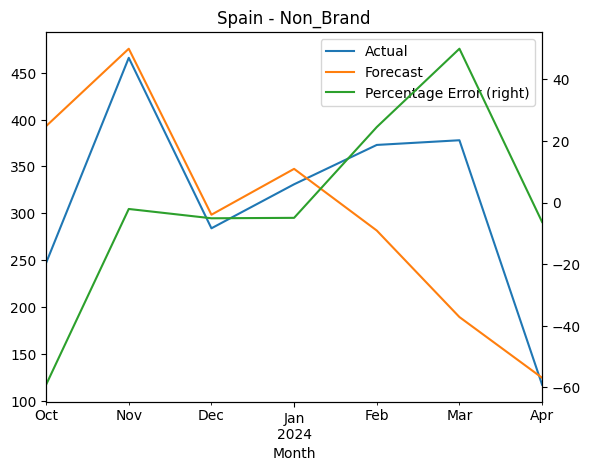

In [ ]:
PlotAccuracyCharts(new_accuracy_df, New_Cuts_df, query_item_list)


## Trick
##### When accuracy is too lower for certain splits, consider the recent year trend change, instead of running training from the first day of the history, only use the recent years might be helpful. be cautious if using this methodology. Rows in df will need to be dropped before creating pickle files.
##### Below is an example for Google Competitor. Dropping the history data before Jan 1, 2022 will generate better accuracy.  

In [ ]:
# example 
temp_df = df[(df.account_type == 'Google AdWords') & (df.funnel == 'Competitor') & (df.ds >= '2022-01-01')]
temp_cuts_df = new_cuts_df.loc[(new_cuts_df['account_type']=='Google AdWords') & (new_cuts_df['funnel']=='Competitor')]

search_engine = new_repo.Accuracy.ProphetParameterSearch(df = temp_df, cuts_df = temp_cuts_df , breakdown_ls = query_item_list, param_grid = param_grid, customized_holidays = customized_holidays, base_path=base_path) 
grid_brand = search_engine.search() # performs the grid search over the hyper parameter grid. exports a best result .csv table with best hyper parameters by split and a record df .csv table with full hyper parameters results # 


# Model Generator

Generate pickle files where are stored the prophet model trained with the selected hyper parameters, the training data set and the complete data set

In [7]:
model_generator = new_repo.BuildModel.GenerateModelFile()
model_generator.Generate(cuts_df = New_Cuts_df, df = df, customized_holidays = customized_holidays, breakdown_ls = query_item_list, bucket_name = output_bucket, folder_name = folder_name, base_path=base_path)


  0%|          | 0/6 [00:00<?, ?it/s]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Competitor'


19:36:43 - cmdstanpy - INFO - Chain [1] start processing
19:36:43 - cmdstanpy - INFO - Chain [1] done processing
 17%|█▋        | 1/6 [00:00<00:03,  1.57it/s]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Generic'


19:36:43 - cmdstanpy - INFO - Chain [1] start processing
19:36:44 - cmdstanpy - INFO - Chain [1] done processing
 33%|███▎      | 2/6 [00:01<00:02,  1.74it/s]

Breakdown: 'market' = 'US' & 'account_type' = 'Google AdWords' & 'funnel' = 'Brand'


19:36:44 - cmdstanpy - INFO - Chain [1] start processing
19:36:44 - cmdstanpy - INFO - Chain [1] done processing
 50%|█████     | 3/6 [00:01<00:01,  1.66it/s]

Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Competitor'


19:36:45 - cmdstanpy - INFO - Chain [1] start processing
19:36:45 - cmdstanpy - INFO - Chain [1] done processing
 67%|██████▋   | 4/6 [00:02<00:01,  1.65it/s]19:36:45 - cmdstanpy - INFO - Chain [1] start processing


Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Generic'


19:36:45 - cmdstanpy - INFO - Chain [1] done processing
 83%|████████▎ | 5/6 [00:02<00:00,  2.15it/s]

Breakdown: 'market' = 'US' & 'account_type' = 'Bing Ads' & 'funnel' = 'Brand'


19:36:45 - cmdstanpy - INFO - Chain [1] start processing
19:36:46 - cmdstanpy - INFO - Chain [1] done processing
100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


# Exam 
    Exam the performance of an specific split to understand the prediction trend

Import needed packages

In [ ]:
import pickle
from new_repo.BuildModel import MakeFuture
from prophet.plot import plot_plotly, plot_components_plotly

Read the split pickle file 

In [ ]:
# set the pickle file name 
file_name = "US Bing Ads Generic.pkl"
pickle_file_path = base_path + file_name

# open the pickle file 
pickle_in = open(pickle_file_path,'rb') 

# unpickled model is the model to use, training_dataset is used to get historical spend
unpickled_model, training_dataset, model_df = pickle.load(pickle_in)


Set a copy of the analytical file and some splits variables

In [ ]:
analytical_file_copy = analytical_file_df.copy() # set the analytical file copy
market = 'US' # set the first split breakdown variable value
account_type = 'Bing Ads' # set the second split breakdown variable value
funnel = 'Generic' # set the third split breakdown variable value


Filter the analytical file for just the selected split

In [ ]:
spend_df_for_forecast = analytical_file_copy[(analytical_file_copy['market'] == market) & (analytical_file_copy['account_type'] == account_type) & \
                                              (analytical_file_copy['funnel'] == funnel)].copy()

spend_df_for_forecast['ds'] = pd.to_datetime(spend_df_for_forecast.ds)

for i in New_Cuts_df.loc[(New_Cuts_df['market']=='US') & (New_Cuts_df['account_type']=='Bing Ads') & (New_Cuts_df['funnel']=='Generic')].itertuples(): # get the itertuple for 
     pass 


Create the future data frame and predict using the prophet model

In [ ]:

# create the future data frame
future = MakeFuture(model = unpickled_model, model_df = training_dataset, values = i, periods = 183, future_input_df = spend_df_for_forecast)
forecast = unpickled_model.predict(future) # predict the model with the future data frame


Plot components of the prophet forecast and plot the forecast

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:351: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:354: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result

/opt/conda/lib/python3.10/site-packages/prophet/plot.py:228: FutureWarning:

The behavio

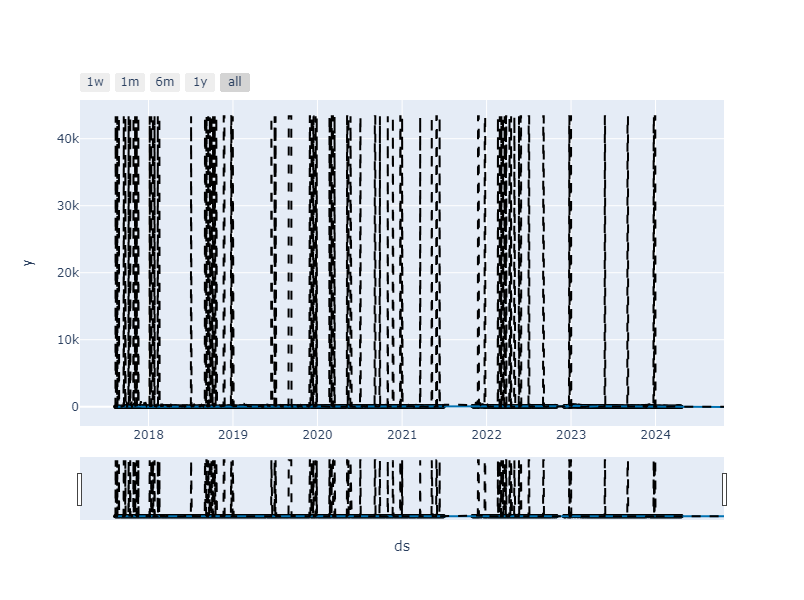

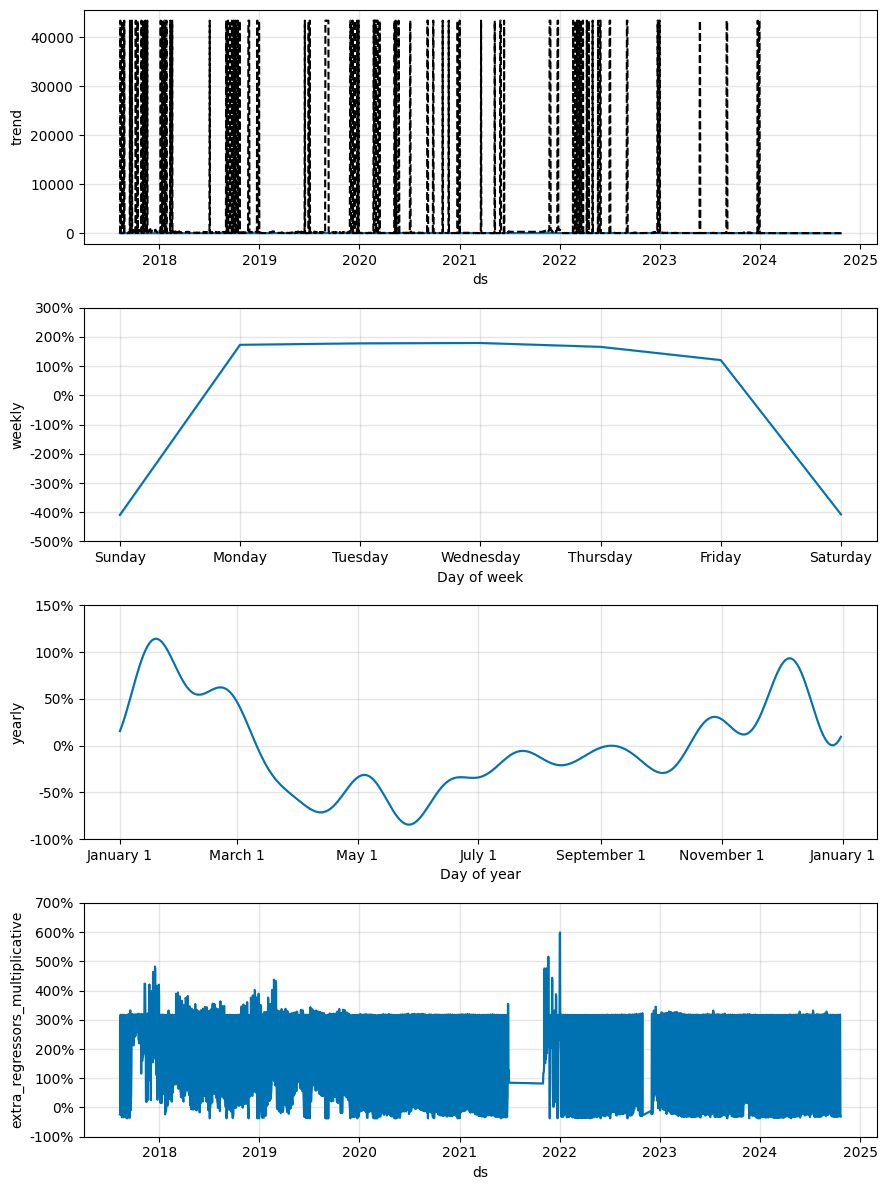

In [ ]:
unpickled_model.plot_components(forecast) # plot components
plot_plotly(unpickled_model, forecast) # plot the forecast model

# Constraint Setting

In [14]:
bounds = New_Cuts_df.copy()
bounds['MinWeight'] = 0.8
bounds['MaxWeight'] = 1.2
bounds

constraint_file_generator = ConstraintFileGenerator(config_dict = config_dict, analytical_file_df = analytical_file_df)
constraint_file = constraint_file_generator.Generate(bounds = bounds)


In [17]:
constraint_file.to_csv(constraint_file_name)
# constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)

### If need to customized some constraints run this part

In [ ]:
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MinWeight'] = 0.7
constraint_file.loc[constraint_file['Month'].isin(['Nov']), 'MaxWeight'] = 0.8


In [17]:
constraint_file.to_csv(constraint_file_name)
# constraint_file_generator.SaveFile(output_bucket, folder_name, constraint_file_name)